In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spop
import datetime
import pickle as pkl
import pandas as pd
import matplotlib.dates as mdates
from scipy.interpolate import interp1d, CubicSpline

# 0. Methods

In [2]:
# u_ss, v_ss, A, phi are all vectors in z
def inertial_oscillation(u_ss, v_ss, A, phi, f, t):
    u = u_ss + A * np.sin(f*t + phi)
    v = v_ss + A * np.cos(f*t + phi)
    return (u, v)

# computed for a single altitude z, with constants that do not vary with z
def ekman_taylor(Ug0, Ugz, z, H, A):
    [ug, vg] = Ug0 + Ugz * z
    [ugz, vgz] = Ugz
    [ug0, vg0] = Ug0
    u0 = ((2+A)*ug0 + (1+A)*H*ugz - (A*vg0 - H*vgz)) / (1 + (1+A)**2)
    v0 = ((2+A)*vg0 + (1+A)*H*vgz + (A*ug0 - H*ugz)) / (1 + (1+A)**2)
    eta = z / H
    u = ug + np.exp(-eta)*((u0 - ug0)*np.cos(eta) + (v0 - vg0)*np.sin(eta))
    v = vg + np.exp(-eta)*((v0 - vg0)*np.cos(eta) - (u0 - ug0)*np.sin(eta))
    return [u, v]

# computed for a time series ts
def coupled_IO_EkT(z, ts, Ug0, Ugz, H, A, f, A_io, phi):
    u_ss = np.zeros_like(z)
    v_ss = np.zeros_like(z)
    for (i, z) in enumerate(z):
        (u, v) = ekman_taylor(Ug0, Ugz, z, H, A)
        u_ss[i] = u
        v_ss[i] = v
    
    u_model = np.zeros((len(u_ss), len(ts)))
    v_model = np.zeros((len(v_ss), len(ts)))

    for (j, t) in enumerate(ts):
        (u, v) = inertial_oscillation(u_ss, v_ss, A_io, phi, f, t)
        u_model[:, j] = u[:]
        v_model[:, j] = v[:]

    return (u_model, v_model)

In [3]:
def extrapolate_A_in_z(A_like, z_meas, z_full):
    spline = CubicSpline(z_meas, A_like, bc_type='not-a-knot')
    A_full = spline(z_full)
    return A_full

def extrapolate_phi_in_z(phi_like, z_meas, z_full):
    func = interp1d(z_meas, phi_like, bounds_error=False, fill_value=(phi_like[0], phi_like[-1]))
    phi_full = func(z_full)
    return phi_full

In [4]:
def rews(ws, z_full, z_hub=150.0, d_rotor=240.0):
    rews = 0.0
    A_sum = 0.0
    dz = z_full[1] - z_full[0]
    for (i, z) in enumerate(z_full):
        if z <= z_hub + d_rotor/2 and z >= z_hub - d_rotor/2:
            dA = 2 * np.sqrt((d_rotor/2)**2 - (z - z_hub)**2) * dz
            A_sum += dA
            rews += ws[i]**3 * dA
    rews = (rews / A_sum)**(1/3)
    return rews

In [5]:
def monotonic_similar_profile(u_llj, v_llj, ts, z_full):
    ws_llj = np.sqrt(u_llj**2 + v_llj**2)
    ws_mon = np.zeros_like(ws_llj)
    for (j, t) in enumerate(ts):
        (V_hub, z_hub, alpha) = fit_normal_wind_profile(ws_llj[:,j], z_full)
        ws_mon[:,j] = normal_wind_profile(z_full, V_hub)
    return ws_mon

def normal_wind_profile(z_full, V_hub, alpha=0.2, z_hub = 150.0):
    V_nwp = V_hub * (z_full / z_hub)**alpha
    return V_nwp

def fit_normal_wind_profile(ws_llj, z_full, z_hub = 150.0, d_rotor = 240.0, alpha=0.2):
    REWS = rews(ws_llj, z_full)
    ws_vhub1 = normal_wind_profile(z_full, 1.0)
    REWS_Vhub1 = rews(ws_vhub1, z_full)
    V_hub = (REWS**3 / REWS_Vhub1) ** (1/3)
    return (V_hub, z_hub, alpha)

In [121]:
def find_veer_wd(u_llj, v_llj, z_full, ts, z_hub = 150.0, d_rotor = 240.0):
    wd_llj = 270 - np.arctan(v_llj/u_llj)/np.pi*180
    wd_mon = wd_llj
    #np.zeros_like(wd_llj)

    # dz = z_full[1] - z_full[0]
    # iz_lower = np.int8((z_hub - d_rotor/2) / dz)
    # iz_upper = np.int8((z_hub + d_rotor/2) / dz)
    # for (j, t) in enumerate(ts):
    #     rotor_mean_wd = np.mean(wd_llj[iz_lower:iz_upper+1,j])
    #     rotor_veer = (wd_llj[iz_upper+1,j] - wd_llj[iz_lower,j]) / d_rotor
    #     wd_mon[:,j] = rotor_mean_wd + (z_full - z_hub)*rotor_veer

    return wd_mon

## Global parameters

In [122]:
lat = 39.68 # E06 NYSERDA
f = 2*7.2921e-5 * np.sin(lat/180 * np.pi) # coriolis term
ts = np.linspace(0.0, 64200.0, 108, endpoint=True)
z_meas = np.linspace(20.0, 200.0, 10, endpoint=True)
z_max = 300.0
z_full = np.linspace(0.0, z_max, 31, endpoint=True)

## WRF & Buoy data

In [123]:
wrf = pd.read_pickle("data/ws_wd_temp_2020.pkl").reset_index()
wrf['time_index'] = pd.to_datetime(wrf['time_index']).dt.tz_localize(None)
wrf = wrf.rename(columns={
    'time_index': 'time',
})

# Step 4: Set coordinates and convert to xarray
wrf_ds = wrf.set_index(['time', 'lat', 'lon', 'altitude']).to_xarray().isel(lat=1, lon=1)
wrf_ds

<xarray.Dataset>
Dimensions:         (time: 8784, altitude: 14)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
    lat             float64 39.55
    lon             float64 -73.43
  * altitude        (altitude) int64 10 20 40 60 80 100 ... 180 200 220 240 260
Data variables:
    wind_speed      (time, altitude) float32 8.82 8.89 9.13 ... 8.22 8.22 8.22
    wind_direction  (time, altitude) float32 243.6 243.7 243.8 ... 349.4 349.3
    temperature     (time, altitude) float32 8.8 8.65 8.43 ... 5.58 5.38 5.18

In [124]:
lidar = xr.open_dataset("data/springtime_E06.nc")
cases = {
    '20200602': [8347, 9211],
    '20200513': [5467, 6331],
    '20200403': [288, 1152],    # 2020-04-03 to 2020-04-09
    'allSpring': [0, -1],
    '20210427': [85000, 85800] # from the full dataset
}
lidar

<xarray.Dataset>
Dimensions:        (t: 12523, z: 10)
Coordinates:
    datetime       (t) datetime64[ns] ...
    height         (z) int64 ...
Dimensions without coordinates: t, z
Data variables:
    windspeed      (t, z) float64 ...
    winddirection  (t, z) float64 ...
    temp           (t) float64 ...
    pressure       (t) float64 ...
    rel_humidity   (t) float64 ...
    waterT         (t) float64 ...
    U              (t, z) float64 ...
    V              (t, z) float64 ...

# 1. April 5, 2020

In [133]:
# Parameters from optimization in low_level_jets notebook #4
A_sol = [2.00798544, 2.22849615, 2.37999955, 2.52865217, 2.87319412,
       3.3479224 , 3.66881104, 3.80117867, 3.8632125 , 3.92861221]
phi_sol = [-2.4221749 , -2.42339026, -2.44738343, -2.4481413 , -2.44002436,
       -2.42369966, -2.43545793, -2.44755539, -2.46596697, -2.47679609]
[ug0, vg0, ugz, vgz, H, A] = [13.644925689368524,
                            -1.2756346980178186,
                            -0.021819100072149343,
                            0.01166601584774272,
                            97.95759207844081,
                            3.121164479776965]

# Extrapolate as necessary
A_io = extrapolate_A_in_z(A_sol, z_meas, z_full)
phi_io = extrapolate_phi_in_z(phi_sol, z_meas, z_full)

# Compute the full modeled time series
(u_llj, v_llj) = coupled_IO_EkT(z_full, ts, np.array([ug0, vg0]), np.array([ugz, vgz]), H, A, f, A_io, phi_io)

# Compute an analogous monotic shear profile
ws_mon = monotonic_similar_profile(u_llj, v_llj, ts, z_full)

# With mean veer and WD
wd_mon = find_veer_wd(u_llj, v_llj, z_full, ts)
u_mon = ws_mon * np.cos(270.0 - wd_mon)
v_mon = ws_mon * np.sin(270.0 - wd_mon)

# No veer
u_mon_nv = ws_mon
v_mon_nv = np.zeros_like(u_mon)

In [134]:
# lidar buoy data
event = '20200403'
t_start = cases[event][0] + 2*24*6 + 17*6
t_end = t_start + 18*6

u_lidar = lidar['U'].isel(t = slice(t_start, t_end))
v_lidar = lidar['V'].isel(t = slice(t_start, t_end))
ws_lidar = np.sqrt(u_lidar**2 + v_lidar**2)
wd_lidar = 270 - np.arctan(v_lidar/u_lidar)/np.pi*180
z_lidar = lidar['height']

dt_start = lidar['datetime'].isel(t = t_start)
dt_end = lidar['datetime'].isel(t = t_end)

# wrf data
ws_wrf = wrf_ds['wind_speed'].sel(time = slice(dt_start, dt_end))
wd_wrf = wrf_ds['wind_direction'].sel(time = slice(dt_start, dt_end))
z_wrf = wrf_ds['altitude']
t_wrf = (wrf_ds['time'].sel(time = slice(dt_start, dt_end)) - wrf_ds['time'].sel(time=dt_start)) / 1e9

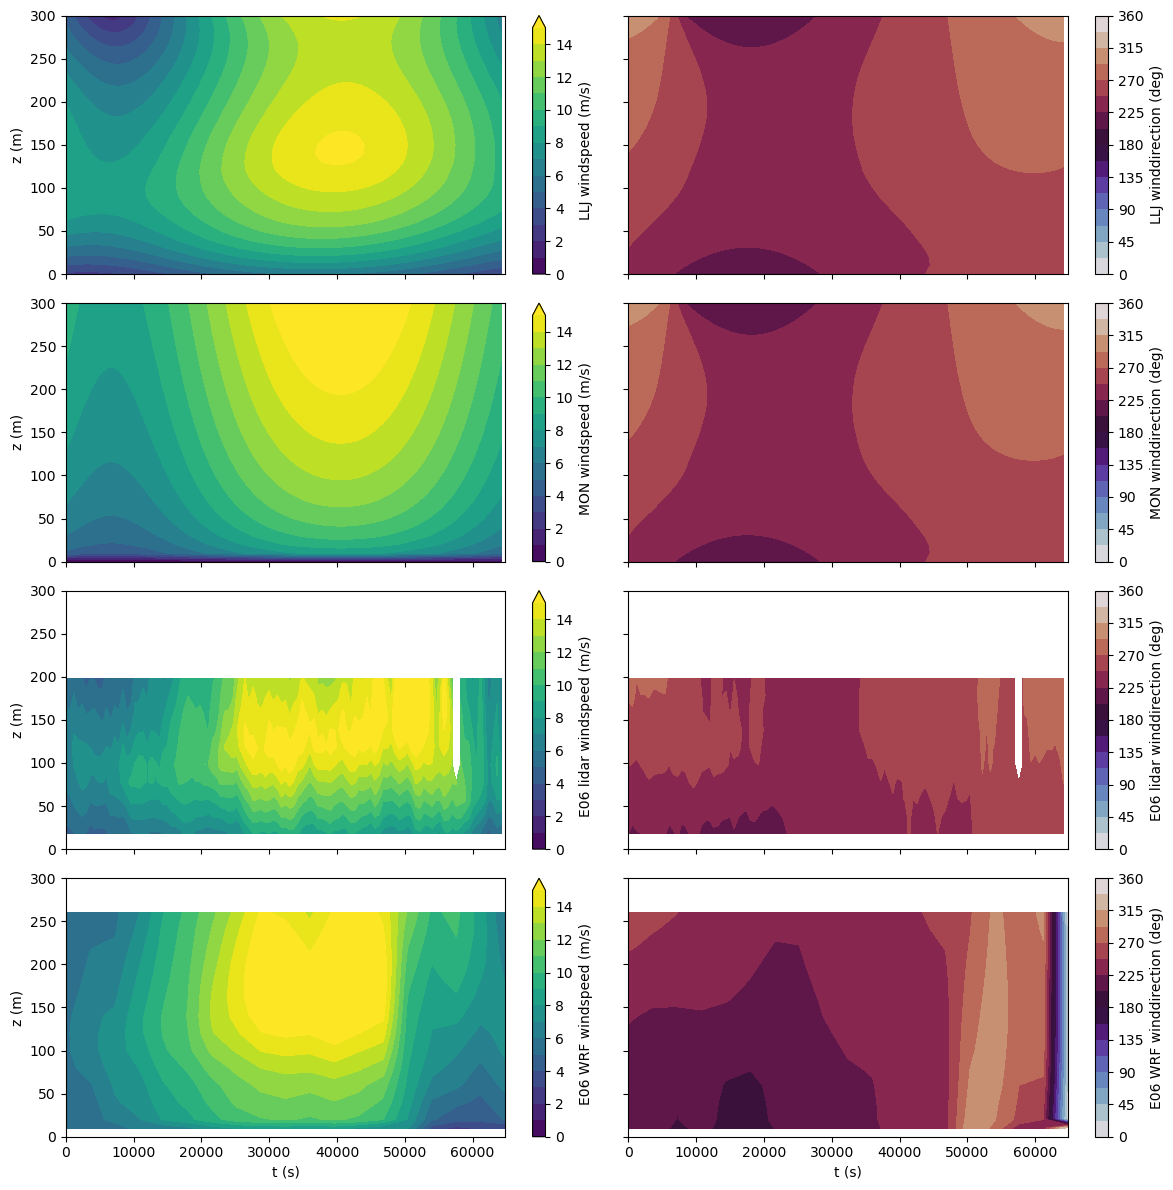

In [135]:
fig, ax = plt.subplots(nrows=4, ncols=2, sharey=True, sharex=True, figsize=(12, 12))
clevels = np.linspace(0.0, 15.0, 16)
clevels2 = np.linspace(0.0, 360.0, 17)

(t, z) = np.meshgrid(ts, z_full)
ws_io = np.sqrt(u_llj**2 + v_llj**2)
wd_io =  270 - np.arctan(v_llj/u_llj)/np.pi*180
CS0 = ax[0][0].contourf(t.T,z.T,ws_io.T, clevels, extend='max')
CS1 = ax[0][1].contourf(t.T,z.T,wd_io.T, clevels2, cmap='twilight')
CS2 = ax[1][0].contourf(t.T, z.T, ws_mon.T, clevels, extend='max')
CS3 = ax[1][1].contourf(t.T, z.T, wd_mon.T, clevels2, cmap='twilight')
# CS2 = ax[2][0].contourf(t.T, z.T, ws_mon.T, clevels, extend='max')
# CS3 = ax[2][1].contourf(t.T, z.T, ws_mon.T*0.0, clevels2, cmap='twilight')

(t, zl) = np.meshgrid(ts, z_lidar)
CS4 = ax[-2][0].contourf(t.T, zl.T, ws_lidar, clevels, extend='max')
CS5 = ax[-2][1].contourf(t.T, zl.T, wd_lidar, clevels2, cmap='twilight')

(tw, zw) = np.meshgrid(t_wrf, z_wrf)
CS6 = ax[-1][0].contourf(tw.T, zw.T, ws_wrf, clevels, extend='max')
CS7 = ax[-1][1].contourf(tw.T, zw.T, wd_wrf, clevels2, cmap='twilight')

for i in range(4):
    ax[i][0].set_ylabel('z (m)')
ax[-1][0].set_xlabel('t (s)')
ax[-1][1].set_xlabel('t (s)')

fig.colorbar(CS0, ax=ax[0][0],label='LLJ windspeed (m/s)')
fig.colorbar(CS1, ax=ax[0][1],label='LLJ winddirection (deg)')
fig.colorbar(CS2, ax=ax[1][0],label='MON windspeed (m/s)')
fig.colorbar(CS3, ax=ax[1][1],label='MON winddirection (deg)')
# fig.colorbar(CS2, ax=ax[2][0],label='MON_NV windspeed (m/s)')
# fig.colorbar(CS3, ax=ax[2][1],label='MON_NV winddirection (deg)')
fig.colorbar(CS2, ax=ax[-2][0],label='E06 lidar windspeed (m/s)')
fig.colorbar(CS3, ax=ax[-2][1],label='E06 lidar winddirection (deg)')
fig.colorbar(CS2, ax=ax[-1][0],label='E06 WRF windspeed (m/s)')
fig.colorbar(CS3, ax=ax[-1][1],label='E06 WRF winddirection (deg)')

plt.tight_layout()
plt.savefig('figures/SI_April5.pdf')

In [136]:
profiles_xr = xr.Dataset(
    data_vars = dict(
        u_llj=(["z","t"], u_llj),
        v_llj=(["z","t"], v_llj),
        u_mon=(["z","t"], u_mon),
        v_mon=(["z","t"], v_mon),
        ws_llj=(["z","t"], ws_io),
        wd_llj=(["z","t"], wd_io),
        ws_mon=(["z","t"], ws_mon),
        wd_mon=(["z","t"], wd_mon),
        ws_lidar=(["zl", "t"], ws_lidar.T.data),
        wd_lidar=(["zl", "t"], wd_lidar.T.data),
        ws_wrf=(["zw", "tw"], ws_wrf.T.data),
        wd_wrf=(["zw","tw"], wd_wrf.T.data)
    ),
    coords=dict(
        t_sec=(["t"], ts),
        z=(["z"], z_full),
        zl=(["zl"], z_lidar.data),
        zw=(["zw"], z_wrf.data),
        tw=(["tw"], t_wrf.data * 1e9),
    )
)
profiles_xr = profiles_xr.assign_coords(case="April 5")
profiles_xr.to_netcdf("data/April5.nc")

# 2. May 15, 2020

In [137]:
# Parameters from optimization in low_level_jets notebook #4
A_sol = [2.0291243 , 2.17961936, 2.40684779, 2.53439411, 2.8572963 ,
       3.2945338 , 3.95209183, 4.46597354, 4.85347256, 5.14624811]
phi_sol = [-3.1110805 , -3.07069772, -3.14059265, -3.14059265, -3.11525664,
       -3.13661336, -3.14059265, -3.14059265, -3.14059265, -3.14059265]
[ug0, vg0, ugz, vgz, H, A] = [23.50242784844371,
                            3.1076113794128686,
                            -0.0349085023379044,
                            0.016379922268969924,
                            149.754138797046,
                            2.3878984756540467]

# Extrapolate as necessary
A_io = extrapolate_A_in_z(A_sol, z_meas, z_full)
phi_io = extrapolate_phi_in_z(phi_sol, z_meas, z_full)

# Compute the full modeled time series
(u_llj, v_llj) = coupled_IO_EkT(z_full, ts, np.array([ug0, vg0]), np.array([ugz, vgz]), H, A, f, A_io, phi_io)

# Compute an analogous monotic shear profile
ws_mon = monotonic_similar_profile(u_llj, v_llj, ts, z_full)

# With mean veer and WD
wd_mon = find_veer_wd(u_llj, v_llj, z_full, ts)
u_mon = ws_mon * np.cos(270.0 - wd_mon)
v_mon = ws_mon * np.sin(270.0 - wd_mon)

# No veer
u_mon = ws_mon
v_mon = np.zeros_like(u_mon)


In [138]:
# lidar buoy data
event = '20200513'
t_start = cases[event][0] + 2*24*6 + 15*6
t_end = t_start + 18*6

u_lidar = lidar['U'].isel(t = slice(t_start, t_end))
v_lidar = lidar['V'].isel(t = slice(t_start, t_end))
ws_lidar = np.sqrt(u_lidar**2 + v_lidar**2)
wd_lidar = 270 - np.arctan(v_lidar/u_lidar)/np.pi*180
z_lidar = lidar['height']

dt_start = lidar['datetime'].isel(t = t_start)
dt_end = lidar['datetime'].isel(t = t_end)

# wrf data
ws_wrf = wrf_ds['wind_speed'].sel(time = slice(dt_start, dt_end))
wd_wrf = wrf_ds['wind_direction'].sel(time = slice(dt_start, dt_end))
z_wrf = wrf_ds['altitude']
t_wrf = (wrf_ds['time'].sel(time = slice(dt_start, dt_end)) - wrf_ds['time'].sel(time=dt_start)) / 1e9

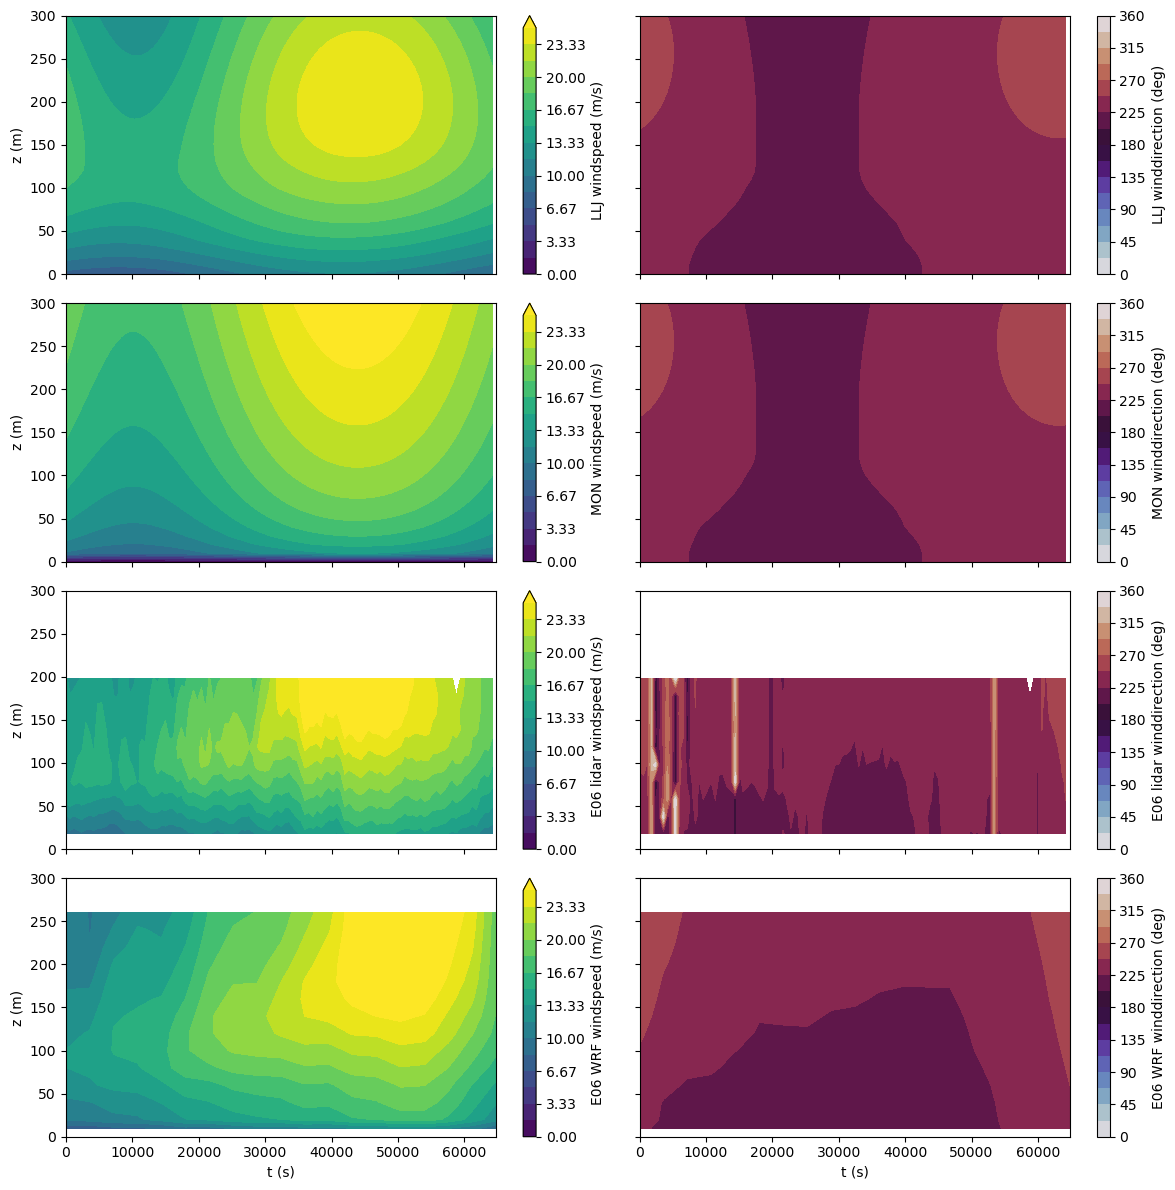

In [139]:
fig, ax = plt.subplots(nrows=4, ncols=2, sharey=True, sharex=True, figsize=(12, 12))
clevels = np.linspace(0.0, 25.0, 16)
clevels2 = np.linspace(0.0, 360.0, 17)

(t, z) = np.meshgrid(ts, z_full)
ws_io = np.sqrt(u_llj**2 + v_llj**2)
wd_io =  270 - np.arctan(v_llj/u_llj)/np.pi*180
CS0 = ax[0][0].contourf(t.T,z.T,ws_io.T, clevels, extend='max')
CS1 = ax[0][1].contourf(t.T,z.T,wd_io.T, clevels2, cmap='twilight')
CS2 = ax[1][0].contourf(t.T, z.T, ws_mon.T, clevels, extend='max')
CS3 = ax[1][1].contourf(t.T, z.T, wd_mon.T, clevels2, cmap='twilight')
# CS2 = ax[2][0].contourf(t.T, z.T, ws_mon.T, clevels, extend='max')
# CS3 = ax[2][1].contourf(t.T, z.T, ws_mon.T*0.0, clevels2, cmap='twilight')

(t, zl) = np.meshgrid(ts, z_lidar)
CS4 = ax[-2][0].contourf(t.T, zl.T, ws_lidar, clevels, extend='max')
CS5 = ax[-2][1].contourf(t.T, zl.T, wd_lidar, clevels2, cmap='twilight')

(tw, zw) = np.meshgrid(t_wrf, z_wrf)
CS6 = ax[-1][0].contourf(tw.T, zw.T, ws_wrf, clevels, extend='max')
CS7 = ax[-1][1].contourf(tw.T, zw.T, wd_wrf, clevels2, cmap='twilight')

for i in range(4):
    ax[i][0].set_ylabel('z (m)')
ax[-1][0].set_xlabel('t (s)')
ax[-1][1].set_xlabel('t (s)')

fig.colorbar(CS0, ax=ax[0][0],label='LLJ windspeed (m/s)')
fig.colorbar(CS1, ax=ax[0][1],label='LLJ winddirection (deg)')
fig.colorbar(CS2, ax=ax[1][0],label='MON windspeed (m/s)')
fig.colorbar(CS3, ax=ax[1][1],label='MON winddirection (deg)')
# fig.colorbar(CS2, ax=ax[2][0],label='MON_NV windspeed (m/s)')
# fig.colorbar(CS3, ax=ax[2][1],label='MON_NV winddirection (deg)')
fig.colorbar(CS2, ax=ax[-2][0],label='E06 lidar windspeed (m/s)')
fig.colorbar(CS3, ax=ax[-2][1],label='E06 lidar winddirection (deg)')
fig.colorbar(CS2, ax=ax[-1][0],label='E06 WRF windspeed (m/s)')
fig.colorbar(CS3, ax=ax[-1][1],label='E06 WRF winddirection (deg)')

plt.tight_layout()
plt.savefig('figures/SI_May15.pdf')


In [140]:
profiles_xr = xr.Dataset(
    data_vars = dict(
        u_llj=(["z","t"], u_llj),
        v_llj=(["z","t"], v_llj),
        u_mon=(["z","t"], u_mon),
        v_mon=(["z","t"], v_mon),
        ws_llj=(["z","t"], ws_io),
        wd_llj=(["z","t"], wd_io),
        ws_mon=(["z","t"], ws_mon),
        wd_mon=(["z","t"], wd_mon),
        ws_lidar=(["zl", "t"], ws_lidar.T.data),
        wd_lidar=(["zl", "t"], wd_lidar.T.data),
        ws_wrf=(["zw", "tw"], ws_wrf.T.data),
        wd_wrf=(["zw","tw"], wd_wrf.T.data)
    ),
    coords=dict(
        t_sec=(["t"], ts),
        z=(["z"], z_full),
        zl=(["zl"], z_lidar.data),
        zw=(["zw"], z_wrf.data),
        tw=(["tw"], t_wrf.data * 1e9),
    )
)
profiles_xr = profiles_xr.assign_coords(case="May 15")
profiles_xr.to_netcdf("data/May15.nc")

# 3. June 3, 2020

In [141]:
# Parameters from optimization in low_level_jets notebook #4
A_sol = [2.26114967, 3.68770764, 4.29829284, 4.50066681, 4.6494946 ,
       4.71730911, 4.79646542, 4.88814777, 4.94984601, 4.89826885]
phi_sol = [-1.31559234, -1.3375867 , -1.26318318, -1.22029833, -1.17609762,
       -1.13138398, -1.09483457, -1.07141242, -1.05016715, -1.02889363]
[ug0, vg0, ugz, vgz, H, A] = [4.89093328604861,
                            2.8165603758773927,
                            0.0021480563543068328,
                            -0.010520234577744508,
                            40.001485083825415,
                            0.425005147884652]

# Extrapolate as necessary
A_io = extrapolate_A_in_z(A_sol, z_meas, z_full)
phi_io = extrapolate_phi_in_z(phi_sol, z_meas, z_full)

# Compute the full modeled time series
(u_llj, v_llj) = coupled_IO_EkT(z_full, ts, np.array([ug0, vg0]), np.array([ugz, vgz]), H, A, f, A_io, phi_io)

# Compute an analogous monotic shear profile
ws_mon = monotonic_similar_profile(u_llj, v_llj, ts, z_full)
# With mean veer and WD
wd_mon = find_veer_wd(u_llj, v_llj, z_full, ts)
u_mon = ws_mon * np.cos(270.0 - wd_mon)
v_mon = ws_mon * np.sin(270.0 - wd_mon)
# No veer
u_mon = ws_mon
v_mon = np.zeros_like(u_mon)


In [142]:
# lidar buoy data
event = '20200602'
t_start = cases[event][0] + 45*6
t_end = t_start + 18*6

u_lidar = lidar['U'].isel(t = slice(t_start, t_end))
v_lidar = lidar['V'].isel(t = slice(t_start, t_end))
ws_lidar = np.sqrt(u_lidar**2 + v_lidar**2)
wd_lidar = 270 - np.arctan(v_lidar/u_lidar)/np.pi*180
z_lidar = lidar['height']

dt_start = lidar['datetime'].isel(t = t_start)
dt_end = lidar['datetime'].isel(t = t_end)

# wrf data
ws_wrf = wrf_ds['wind_speed'].sel(time = slice(dt_start, dt_end))
wd_wrf = wrf_ds['wind_direction'].sel(time = slice(dt_start, dt_end))
z_wrf = wrf_ds['altitude']
t_wrf = (wrf_ds['time'].sel(time = slice(dt_start, dt_end)) - wrf_ds['time'].sel(time=dt_start)) / 1e9

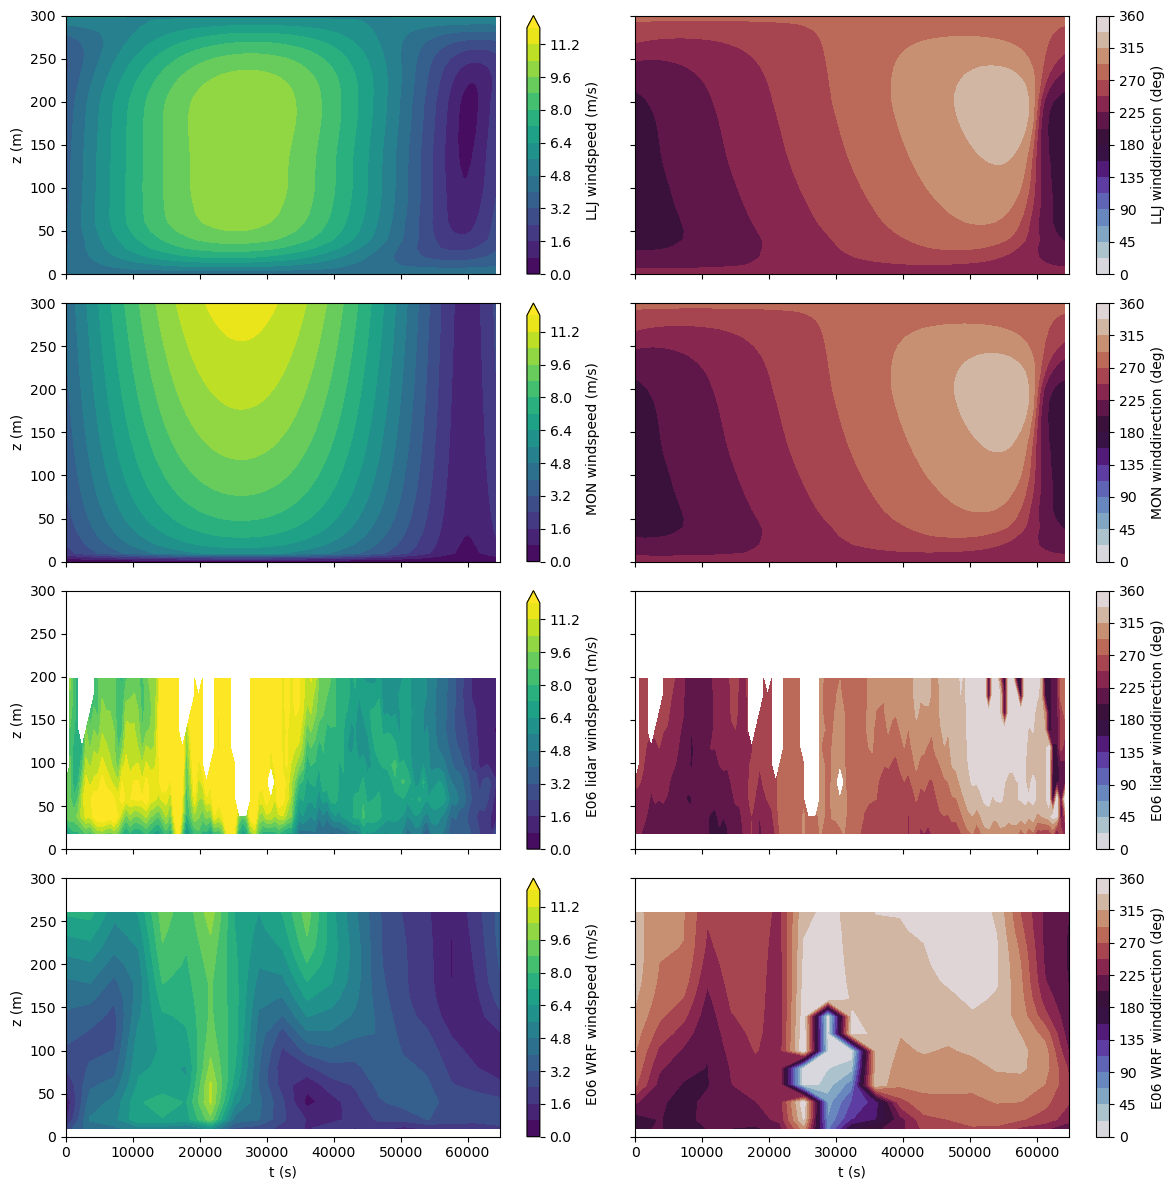

In [143]:
fig, ax = plt.subplots(nrows=4, ncols=2, sharey=True, sharex=True, figsize=(12, 12))
clevels = np.linspace(0.0, 12.0, 16)
clevels2 = np.linspace(0.0, 360.0, 17)

(t, z) = np.meshgrid(ts, z_full)
ws_io = np.sqrt(u_llj**2 + v_llj**2)
wd_io =  270 - np.arctan(v_llj/u_llj)/np.pi*180
CS0 = ax[0][0].contourf(t.T,z.T,ws_io.T, clevels, extend='max')
CS1 = ax[0][1].contourf(t.T,z.T,wd_io.T, clevels2, cmap='twilight')
CS2 = ax[1][0].contourf(t.T, z.T, ws_mon.T, clevels, extend='max')
CS3 = ax[1][1].contourf(t.T, z.T, wd_mon.T, clevels2, cmap='twilight')
# CS2 = ax[2][0].contourf(t.T, z.T, ws_mon.T, clevels, extend='max')
# CS3 = ax[2][1].contourf(t.T, z.T, ws_mon.T*0.0, clevels2, cmap='twilight')

(t, zl) = np.meshgrid(ts, z_lidar)
CS4 = ax[-2][0].contourf(t.T, zl.T, ws_lidar, clevels, extend='max')
CS5 = ax[-2][1].contourf(t.T, zl.T, wd_lidar, clevels2, cmap='twilight')

(tw, zw) = np.meshgrid(t_wrf, z_wrf)
CS6 = ax[-1][0].contourf(tw.T, zw.T, ws_wrf, clevels, extend='max')
CS7 = ax[-1][1].contourf(tw.T, zw.T, wd_wrf, clevels2, cmap='twilight')

for i in range(4):
    ax[i][0].set_ylabel('z (m)')
ax[-1][0].set_xlabel('t (s)')
ax[-1][1].set_xlabel('t (s)')

fig.colorbar(CS0, ax=ax[0][0],label='LLJ windspeed (m/s)')
fig.colorbar(CS1, ax=ax[0][1],label='LLJ winddirection (deg)')
fig.colorbar(CS2, ax=ax[1][0],label='MON windspeed (m/s)')
fig.colorbar(CS3, ax=ax[1][1],label='MON winddirection (deg)')
# fig.colorbar(CS2, ax=ax[2][0],label='MON_NV windspeed (m/s)')
# fig.colorbar(CS3, ax=ax[2][1],label='MON_NV winddirection (deg)')
fig.colorbar(CS2, ax=ax[-2][0],label='E06 lidar windspeed (m/s)')
fig.colorbar(CS3, ax=ax[-2][1],label='E06 lidar winddirection (deg)')
fig.colorbar(CS2, ax=ax[-1][0],label='E06 WRF windspeed (m/s)')
fig.colorbar(CS3, ax=ax[-1][1],label='E06 WRF winddirection (deg)')

plt.tight_layout()
plt.savefig('figures/SI_June3.pdf')


In [144]:
profiles_xr = xr.Dataset(
    data_vars = dict(
        u_llj=(["z","t"], u_llj),
        v_llj=(["z","t"], v_llj),
        u_mon=(["z","t"], u_mon),
        v_mon=(["z","t"], v_mon),
        ws_llj=(["z","t"], ws_io),
        wd_llj=(["z","t"], wd_io),
        ws_mon=(["z","t"], ws_mon),
        wd_mon=(["z","t"], wd_mon),
        ws_lidar=(["zl", "t"], ws_lidar.T.data),
        wd_lidar=(["zl", "t"], wd_lidar.T.data),
        ws_wrf=(["zw", "tw"], ws_wrf.T.data),
        wd_wrf=(["zw","tw"], wd_wrf.T.data)
    ),
    coords=dict(
        t_sec=(["t"], ts),
        z=(["z"], z_full),
        zl=(["zl"], z_lidar.data),
        zw=(["zw"], z_wrf.data),
        tw=(["tw"], t_wrf.data * 1e9),
    )
)
profiles_xr = profiles_xr.assign_coords(case="June 3")
profiles_xr.to_netcdf("data/June3.nc")

# 4. Plotting

In [145]:
ds0 = xr.open_dataset('data/April5.nc')
ds1 = xr.open_dataset('data/May15.nc')
ds2 = xr.open_dataset('data/June3.nc')

ds = xr.concat([ds0, ds1, ds2], dim='case')

ds.to_netcdf('data/all_inflows.nc')

In [146]:
ds

<xarray.Dataset>
Dimensions:   (case: 3, z: 31, t: 108, zl: 10, zw: 14, tw: 19)
Coordinates:
    t_sec     (t) float64 0.0 600.0 1.2e+03 ... 6.3e+04 6.36e+04 6.42e+04
  * z         (z) float64 0.0 10.0 20.0 30.0 40.0 ... 270.0 280.0 290.0 300.0
  * zl        (zl) int64 18 38 58 78 98 118 138 158 178 198
  * zw        (zw) int64 10 20 40 60 80 100 120 140 160 180 200 220 240 260
  * tw        (tw) timedelta64[ns] 00:00:00 01:00:00 ... 17:00:00 18:00:00
  * case      (case) <U7 'April 5' 'May 15' 'June 3'
Dimensions without coordinates: t
Data variables:
    u_llj     (case, z, t) float64 2.559 2.49 2.424 2.362 ... 5.88 5.877 5.873
    v_llj     (case, z, t) float64 1.106 1.17 1.239 ... -0.3822 -0.4013 -0.4203
    u_mon     (case, z, t) float64 -0.0 0.0 -0.0 -0.0 ... 1.773 2.015 2.276 2.55
    v_mon     (case, z, t) float64 -0.0 0.0 0.0 -0.0 -0.0 ... 0.0 0.0 0.0 0.0
    ws_llj    (case, z, t) float64 2.788 2.751 2.722 2.701 ... 5.892 5.89 5.888
    wd_llj    (case, z, t) float64 246.6 244.8 242.9 241.0 ... 273.7 273.9 274.1
    ws_mon    (case, z, t) float64 0.0 0.0 0.0 0.0 ... 1.773 2.015 2.276 2.55
    wd_mon    (case, z, t) float64 246.6 244.8 242.9 241.0 ... 273.7 273.9 274.1
    ws_lidar  (case, zl, t) float64 4.621 4.78 4.967 ... 1.355 0.9168 0.9738
    wd_lidar  (case, zl, t) float64 225.1 222.7 224.0 ... 214.5 279.1 267.7
    ws_wrf    (case, zw, tw) float32 5.29 5.12 5.26 6.57 ... 1.7 0.89 1.97 3.49
    wd_wrf    (case, zw, tw) float32 217.8 209.3 199.2 ... 268.8 220.9 202.9

In [147]:
def plot_wd_ws_snapshots(ax, case, timestamps):
    data = ds.sel(case=case)
    for (i, timestamp) in enumerate(timestamps):
        it = int(timestamp * 3600.0 / 600.0)
        # windspeed
        line = ax[0].plot(data['ws_llj'].isel(t = it), data['z'], '-', label=str(timestamp)+'hr',color=plt.cm.copper(timestamp/18))
        color = line[-1].get_color()
        ax[0].plot(data['ws_mon'].isel(t = it), data['z'], '--', color=color)

        # winddirection
        if i == 0:
            lbl = ''
        else:
            lbl = '_'
        ax[1].plot(data['wd_llj'].isel(t = it), data['z'], '-', color=color, label=lbl+'LLJ')
        ax[1].plot(data['wd_mon'].isel(t = it), data['z'], '--', color=color, label=lbl+'MS')
        
        # turbine reference points
        ax[0].axhline(150.0, 0, 1, ls=':',color='k')
        ax[0].axhspan(30.0, 270.0, 0, 1, alpha=0.05, color='k')
        ax[1].axhline(150.0, 0, 1, ls=':',color='k')
        ax[1].axhspan(30.0, 270.0, 0, 1, alpha=0.05, color='k')
        
    ax[0].set_ylabel('altitude (m)')
    ax[0].set_xlabel('windspeed (m/s)')
    ax[0].set_xlim([0.0, 28.0])
    ax[1].set_xlim([200.0, 310.0])
    ax[1].set_xlabel('direction (deg)')

    ax[0].text(-5.0, 120.0, case, rotation=90,fontsize=14)

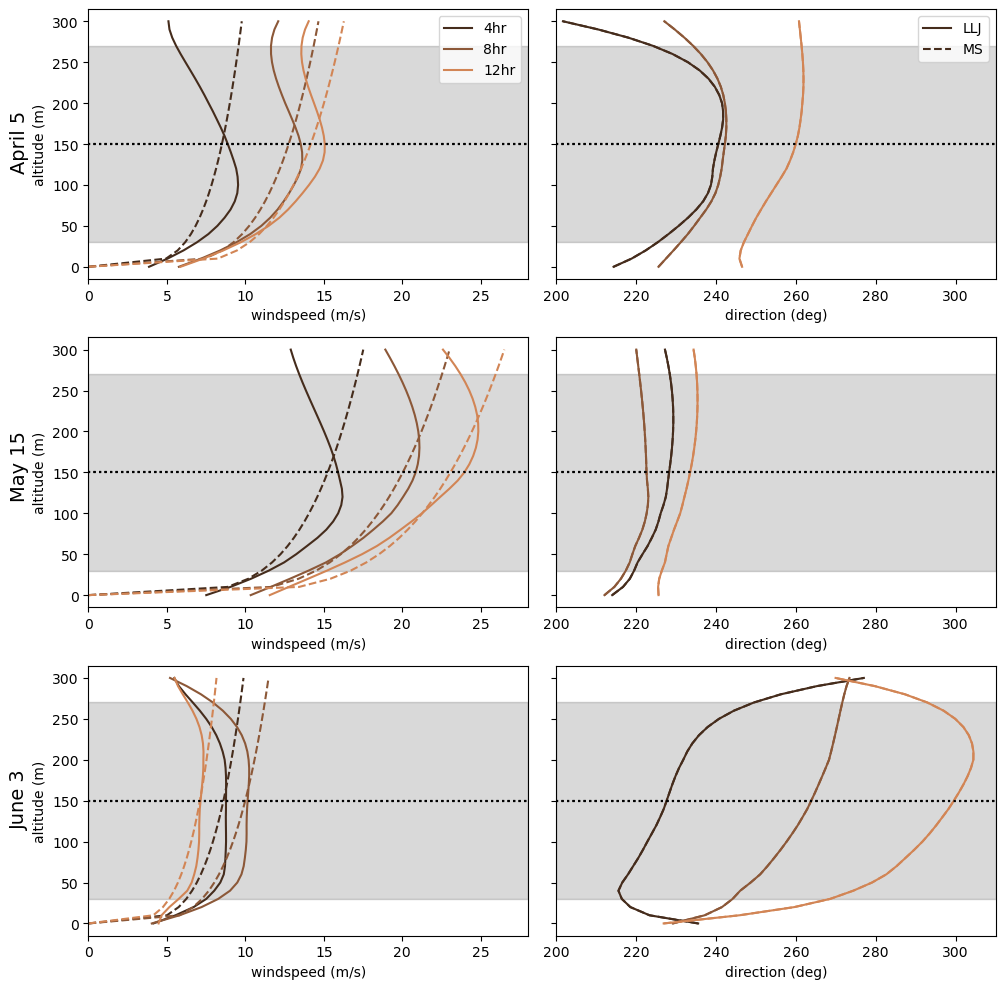

In [148]:
fig, ax = plt.subplots(3,2,figsize=(10, 10), sharey=True)
timestamps = [4, 8, 12]
for (j, case) in enumerate(['April 5', 'May 15', 'June 3']):
    plot_wd_ws_snapshots(ax[j], case, timestamps)

ax[0][0].legend()
ax[0][1].legend()
plt.tight_layout()

plt.savefig('figures/fig1_windsetups.pdf', bbox_inches='tight')

In [149]:
ds['HH_WS_LLJ'] = ds['ws_llj'].sel(z=150)
ds['HH_WS_MON'] = ds['ws_mon'].sel(z=150)
ds['mean_veer_LLJ'] = ds['wd_llj'].differentiate('z').sel(z=slice(30, 240)).mean('z')/10.0
ds['mean_veer_MON'] = ds['wd_mon'].differentiate('z').sel(z=slice(30, 240)).mean('z')/10.0
ds['mean_shear_LLJ'] = ds['ws_llj'].differentiate('z').sel(z=slice(30, 240)).mean('z')/10.0
ds['mean_shear_MON'] = ds['ws_mon'].differentiate('z').sel(z=slice(30, 240)).mean('z')/10.0
ds['max_ws_LLJ'] = ds['ws_llj'].sel(z=slice(30, 240)).max('z')
ds['max_ws_MON'] = ds['ws_mon'].sel(z=slice(30, 240)).max('z')

tmp = ds['ws_llj'].differentiate('z').sel(z=slice(30, 240))
ds['neg_shear_LLJ'] = tmp.where(tmp < 0.0).mean('z')/10.0

In [150]:
iz_max = ds['ws_llj'].sel(z=slice(30, 240)).argmax('z')
tmp = np.zeros_like(ds['max_ws_LLJ'])
for (t, tsec) in enumerate(ds['t_sec']):
    for (c, case) in enumerate(ds['case']):
        tmp[c, t] = ds['z'].isel(z = iz_max.values[c,t])

ds['z_max_LLJ'] = ('case','t'), tmp
ds['z_max_MON'] = ('case', 't'), np.zeros_like(tmp)*0.0+240.0

In [152]:
def plot_scatter(ax, property1, property2, property1_label, property2_label, both='True'):
    for case in ds['case']:
        if both:
            for type in ['LLJ','MON']:
                data1 = ds[property1+'_'+type].rolling(t=6).mean().isel(t=slice(5,None,6))
                data2 = ds[property2+'_'+type].rolling(t=6).mean().isel(t=slice(5,None,6))
                if type=='LLJ':
                    line = ax.plot(data1.sel(case=case), data2.sel(case=case), label=str(case.values)+' LLJ', marker='^', fillstyle='none', linestyle='none', ms=8)
                else:
                    color = line[-1].get_color()
                    ax.plot(data1.sel(case=case), data2.sel(case=case), label=str(case.values)+' MS', marker='.', fillstyle='full', linestyle='none', ms=10, color=color)
        else:
            data1 = ds[property1].isel(t=slice(0, -1, 6))
            data2 = ds[property2].isel(t=slice(0, -1, 6))
            ax.plot(data1.sel(case=case), data2.sel(case=case.values), label=case, marker='^', fillstyle='none', linestyle='none', ms=8)
    
    ax.set_xlabel(property1_label)
    ax.set_ylabel(property2_label)

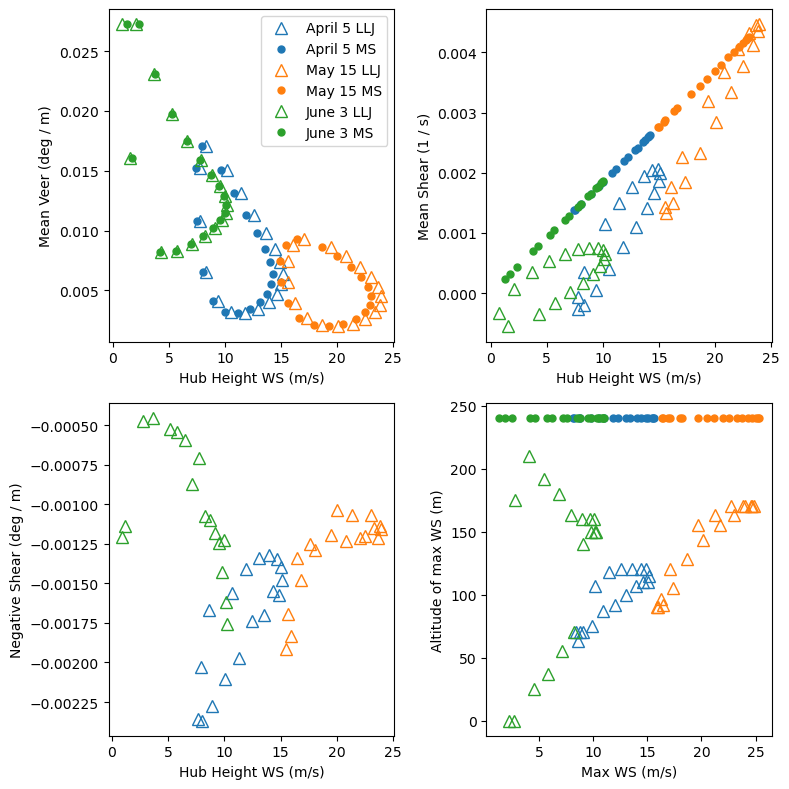

In [153]:
(fig, ax) = plt.subplots(2, 2, figsize=(8,8))
plot_scatter(ax[0][0], 'HH_WS', 'mean_veer', 'Hub Height WS (m/s)', 'Mean Veer (deg / m)', both=True)
ax[0][0].legend()
plot_scatter(ax[0][1], 'HH_WS', 'mean_shear', 'Hub Height WS (m/s)', 'Mean Shear (1 / s)', both=True)
plot_scatter(ax[1][0], 'HH_WS_LLJ', 'neg_shear_LLJ', 'Hub Height WS (m/s)', 'Negative Shear (deg / m)', both=False)
plot_scatter(ax[1][1], 'max_ws', 'z_max', 'Max WS (m/s)', 'Altitude of max WS (m)', both=True)

plt.tight_layout()
plt.savefig('figures/fig2_setup_stats.pdf')

In [154]:
ds.to_netcdf('data/processed_inflows.nc')